PyTorchでニューラルネットを作って計算するとは、そもそも何をしているのだろうか。<br>
本を読むと偏微分方程式とかナブラの記号がでてきたりするけれど、その数式とプログラムのコードがどう関係しているのか全くわからない！<br>
……というところの差分を少しでも埋めるためにコードを書いてみました。

【参考】
https://www.hellocybernetics.tech/entry/2019/07/18/222317#Tensor%E3%81%AE%E5%BE%AE%E5%88%86

In [5]:
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

### １．x と yの方程式で微分を計算する

二次方程式
$$
y = 3x^2
$$
ここでyをxで微分すると、
$$
\frac{d y}{d x}=6x
$$
ここで、x=4のとき、yの傾きは24。<br>
このような初歩的な微分の計算をPyTorchで書いてみる。

In [47]:
# xの微分宣言
x = torch.tensor([4.], requires_grad=True)

# yとxの関係を定義
y = 3 * x **2

# yをxで微分
y.backward()

# 傾きを求める
float(x.grad)

24.0

あとで微分するときは、あらかじめ変数をrequires_grad=Trueと宣言しておく。<br>
上の例ではxを初期化するときに宣言している。あとからこれを付与することもできる。

> x.requires_grad_(True)

メソッドの最後の_は、xそのものを変更することを示す。

### ２．2変数の関数を使って偏微分してみる
$$
y = 3x_1^2 + 4x_2^2
$$
$$
\frac{\partial y}{\partial x_1}=6x_1
$$
$$
\frac{\partial y}{\partial x_2}=8x_2
$$
$$
\nabla y=(\frac{\partial y}{\partial x_1}, \frac{\partial y}{\partial x_2})=( 6x_1, 8x_2)
$$
デルタは前進差分(forward)なので、逆の後退差分(backward)としてナブラが使われる。
$$
\Delta : delta
$$
$$
\nabla : nabla
$$
実際にPyTorchのコードで書いてみると以下の通り。

In [48]:
# xの微分宣言
x1 = torch.tensor([4.], requires_grad=True)
x2 = torch.tensor([5.], requires_grad=True)

# yとxの関係を式で定義
y = 3 * x1 **2 + 4 * x2 **2

# yをx1とx2で偏微分する。x1で偏微分するときはx2は定数項なので微分すると消える。
y.backward()

# 傾きを求める
print(float(x1.grad))
print(float(x2.grad))

24.0
40.0


### ３．ニューラルネットで関数を近似する
関数
$$
y = f(x)
$$
を、ニューラルネットで近似することを考える。例題として、
$$
y = 2 x +1 \quad (-10 \leqq x \leqq 10)
$$
から始めてみよう。まずは近似される値を作っておく。

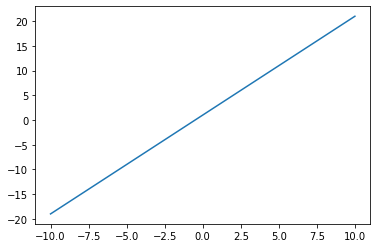

In [65]:
# -10から10までxの値をとる。
X = torch.linspace(-10, 10, 1000).reshape(-1, 1)

# 近似される値として、Yを決める
Y = 2 * X + 1

# (X, Y)をプロットしてみる
plt.plot(X, Y)
pass

近似する側のニューラルネットを定義する。

In [69]:
# パラメータの初期化＆あとで微分するよ宣言
W1 = torch.randn(  1,  64).requires_grad_(True)
W2 = torch.randn( 64,  64).requires_grad_(True)
W3 = torch.randn( 64,   1).requires_grad_(True)

Xを入力値として、Yを予想してみる。予想値をHとする。W1, W2, W3はランダム値なので、もちろんでたらめな計算結果になる。<br>
（なぜsigmoid？なぜ行列の掛け算？など疑問はある）

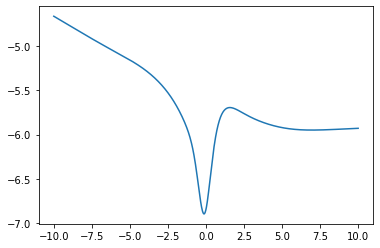

In [70]:
h1 = torch.sigmoid(torch.mm(X, W1))
h2 = torch.sigmoid(torch.mm(h1, W2))
H  = torch.mm(h2, W3)

# 試しにXとHをプロットしてみる。上の初期化をやり直すと結果も変わる。
plt.plot(X, H.detach().numpy())
pass

理想的な結果に近づけるため、まずは誤差(error)を計算しておく。

誤差はYとHの差を二乗平均して得られる。

In [32]:
error = ((Y - H)**2).mean()
error

tensor(205.6459, grad_fn=<MeanBackward0>)

YとHの傾き(微分)を求めて、傾きがゼロに近づくようにしている。

In [33]:
error.backward()

学習率LearningRateに従って、傾きを大きく調整したり、小さく調整したりする。

In [34]:
LearningRate = 0.01
W1.data = W1.data - LearningRate * W1.grad.data
W2.data = W2.data - LearningRate * W2.grad.data
W3.data = W3.data - LearningRate * W3.grad.data

一回の学習が終わったら、メモリを開放する

In [ ]:
W1.grad.detach_().zero_()
W2.grad.detach_().zero_()
W3.grad.detach_().zero_()

あとは学習を繰り返して理想の値に近づけてゆく。<br>初期化の段階からまとめると、以下の通り。

In [63]:
images = []
fig, ax = plt.subplots(figsize=(5,5))
text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

LearningRate = 0.001
W1 = torch.randn(  1,  64).requires_grad_(True)
W2 = torch.randn( 64,  64).requires_grad_(True)
W3 = torch.randn( 64,   1).requires_grad_(True)

for i in range(150):
    h1 = torch.sigmoid(torch.mm(X, W1))
    h2 = torch.sigmoid(torch.mm(h1, W2))
    H  = torch.mm(h2, W3)

    error = ((Y - H)**2).mean()
    error.backward()

    ax.plot(X.numpy(), Y.numpy())
    text = ax.text(0.02, 0.95, 'Iteration:%3d Error:%1.3f' % (i, error), transform=ax.transAxes)
    image = ax.plot(X.numpy(), H.detach().numpy())
    images.append(image + [text])

    # 傾き方向に少しだけ修正する
    W1.data = W1.data - LearningRate * W1.grad.data
    W2.data = W2.data - LearningRate * W2.grad.data
    W3.data = W3.data - LearningRate * W3.grad.data

    W1.grad.detach_().zero_()
    W2.grad.detach_().zero_()
    W3.grad.detach_().zero_()

# 変化を動画で表示する
ani = animation.ArtistAnimation(fig, images)
ani.save('grad.mp4') # FFMpegなどがインストールされていないときはエラーになるかもしれません
display(HTML(ani.to_html5_video()))

# 最後に余計なものが表示されないようにする
plt.close()

- グラフに表示されるError（誤差）の値がだんだん小さくなることに注目
- イテレーションの回数を増やしてみる手もある

### ４．自由に試してみる

目標とする関数を変更して試してみよう。
$$
y = x^2
$$
他にも、学習率を変更する、繰り返す回数を変更するなど試してみよう。

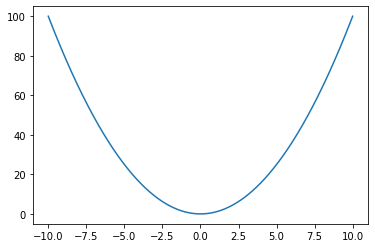

In [6]:
# -10から10までxの値をとる。reshapeはなんのため？
X = torch.linspace(-10, 10, 1000).reshape(-1, 1)

# 近似される値として、Yを決める
Y = X ** 2

# (X, Y)をプロットしてみる
plt.plot(X, Y)

In [7]:
images = []
fig, ax = plt.subplots(figsize=(5,5))
text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# ランダム値の取られ方によっては表示範囲が極端になるので、調整したい場合はこちらで定義域・値域を定める
ax.set_xlim(-10, 10)
ax.set_ylim(0, 100) 

LearningRate = 0.01
W1 = torch.randn(  1, 256).requires_grad_(True)
W2 = torch.randn(256, 256).requires_grad_(True)
W3 = torch.randn(256,   1).requires_grad_(True)

for i in range(5000):
    h1 = torch.sigmoid(torch.mm(X, W1))
    h2 = torch.sigmoid(torch.mm(h1, W2))
    H  = torch.mm(h2, W3)

    error = ((Y - H)**2).mean()
    error.backward()

    if i % 10 == 0:
        ax.plot(X.numpy(), Y.numpy())
        text = ax.text(0.02, 0.95, 'Iteration:%3d Error:%1.3f' % (i, error), transform=ax.transAxes)
        image = ax.plot(X.numpy(), H.detach().numpy())
        images.append(image + [text])

    # 傾き方向に少しだけ修正する
    W1.data = W1.data - LearningRate * W1.grad.data
    W2.data = W2.data - LearningRate * W2.grad.data
    W3.data = W3.data - LearningRate * W3.grad.data

    W1.grad.detach_().zero_()
    W2.grad.detach_().zero_()
    W3.grad.detach_().zero_()

# 変化を動画で表示する
ani = animation.ArtistAnimation(fig, images)
ani.save('grad.mp4')
display(HTML(ani.to_html5_video()))

# 最後に余計なものが表示されないようにする
plt.close()

表示されるアニメーションでグラフがぶるぶるしているのは、振動などと呼ばれて学習率の値が大きいことが原因です。

学習率（Learning Rate）を繰り返しのたびに少しずつ0に近づけてゆく方法

In [ ]:
images = []
fig, ax = plt.subplots(figsize=(5,5))
text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

LearningRate = 0.01
W1 = torch.randn(  1, 256).requires_grad_(True)
W2 = torch.randn(256, 256).requires_grad_(True)
W3 = torch.randn(256,   1).requires_grad_(True)

for i in range(5000):
    h1 = torch.sigmoid(torch.mm(X, W1))
    h2 = torch.sigmoid(torch.mm(h1, W2))
    H  = torch.mm(h2, W3)

    error = ((Y - H)**2).mean()
    error.backward()

    if i % 10 == 0:
        ax.plot(X.numpy(), Y.numpy())
        text = ax.text(0.02, 0.95, 'Iteration:%3d Error:%1.3f' % (i, error), transform=ax.transAxes)
        image = ax.plot(X.numpy(), H.detach().numpy())
        images.append(image + [text])

    # 傾き方向に少しだけ修正する
    W1.data = W1.data - LearningRate * W1.grad.data
    W2.data = W2.data - LearningRate * W2.grad.data
    W3.data = W3.data - LearningRate * W3.grad.data

    W1.grad.detach_().zero_()
    W2.grad.detach_().zero_()
    W3.grad.detach_().zero_()

    LearningRate *= 0.999 # 学習率をちょっと減らして繰り返し

# 変化を動画で表示する
ani = animation.ArtistAnimation(fig, images)
ani.save('grad.mp4')
display(HTML(ani.to_html5_video()))

# 最後に余計なものが表示されないようにする
plt.close()